# The Softmax Algorithm

The problem with the epsilon-Greedy algorithm: it explores options completely at random without any concern about their merits. For example, in one scenario (call it Scenario A), you might have two arms, one of which rewards you 10% of the time and the other rewards you 13% of the time. In Scenario B, the two arms might reward you 10% of the time and 99% of the time. In both of these scenarios, the probability that the epsilon-Greedy algorithm explores the worse arm is exactly the same (it’s `epsilon` / 2), despite the inferior arm in Scenario B being, in relative terms, much worse than the inferior arm in Scenario A.

This is a problem for several reasons:
- If the difference in reward rates between two arms is small, you’ll need to explore a lot more often than 10% of the time to correctly determine which of the two options is actually better.
- In contrast, if the difference is large, you need to explore a lot less than 10% of the time to correctly estimate the better of the two options. For that reason, you’ll end up losing a lot of reward by exploring an unambiguously inferior option in this case. When we first described the epsilon-Greedy algorithm, we said that we wouldn’t set epsilon = 1.0 precisely so that we wouldn’t waste time on inferior options, but, if the difference between two arms is large enough, we end up wasting time on inferior options simply because the epsilon-Greedy algorithm always explores completely at random.

Putting these two points together, it seems clear that there’s a qualitative property missing from the epsilon-Greedy algorithm. We need to make our bandit algorithm cares about the known differences between the estimated values of the arms when our algorithm decides which arm to explore. We need structured exploration rather than the haphazard exploration that the epsilon-Greedy algorithm provides.

The first algorithm we’ll describe that takes this structural information into account is called the Softmax algorithm. The Softmax algorithm tries to cope with arms differing in estimated value by explicitly incorporating information about the reward rates of the available arms into its method for choosing which arm to select when it explores.

You can get an initial intuition for how the Softmax algorithm handles this problem by imagining that you choose each arm in proportion to its estimated value. Suppose that you have two arms, A and B. Now imagine that, based on your past experiences, these two arms have had two different rates of success: `rA` and `rB`. With those assumptions, the most naive possible implementation of a Softmax-like algorithm would have you choose Arm A with probability `rA / (rA + rB)` and Arm B with probability `rB / (rA + rB)`

In code this would look like:

In [1]:
import random

def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        if cum_prob > z:
            return i
    return len(probs) - 1

def select_arm(self):
    z = sum(self.values)
    probs = [v / z for v in self.values]
    return categorical_draw(probs)

In practice, this very naive algorithm isn’t something people actually use. To reconstruct the algorithm people actually use, we need to make two changes to it.

First, we will calculate a different scale for reward rates by exponentiating our estimates of `rA` and `rB`. Using this new scale, we will choose Arm A with probability `exp(rA) / (exp(rA) + exp(rB))` and Arm B with probability `exp(rB) / (exp(rA) + exp(rB))`. This naive exponential rescaling has the virtue of not behaving strangely if you someone used negative numbers as rates of success, since the call to exp will turn any negative numbers into positive numbers and insure that the negative numbers in the denominator of these fractions can’t cancel out any positive numbers that may be found in the denominator.

More importantly, this exponentiation trick brings us very close to the full Softmax algorithm. In fact, plain exponential rescaling gives us the Softmax algorithm if you hardcoded one of the configurable parameters that the standard Softmax algorithm possesses. This additional parameter is a different sort of scaling factor than the exponentiation we just introduced.

This new type of scaling factor is typically called a temperature parameter based on an analogy with physics in which systems at high temperatures tend to behave randomly, while they take on more structure at low temperatures. In fact, the full Softmax algorithm is closely related to a concept called the Boltzmann distribution in physics, which is used to describe how groups of particles behave.

We’ll call this new temperature parameter tau. We introduce `tau` to produce the following new algorithm:
- At time T, select one of the two arms with probabilities computed as follows:
    - `exp(rA / tau) / (exp(rA / tau) + exp(rB / tau))`
    - `exp(rB / tau) / (exp(rA / tau) + exp(rB / tau))`
    
- For whichever arm you picked, update your estimate of the mean using the same update rule we used for the epsilon-Greedy algorithm.

In [12]:
import numpy as np

"""
Success rate of arm A is x3 less than of B. 
"""
success_rate_arm_a = 0.2
success_rate_arm_b = 0.6
temp = 0.1

In [13]:
# Prob of selecting Arm A
np.exp(success_rate_arm_a / temp) / (np.exp(success_rate_arm_a / temp) + np.exp(success_rate_arm_b / temp))

0.017986209962091573

In [14]:
# Prob of selecting Arm B
np.exp(success_rate_arm_b / temp) / (np.exp(success_rate_arm_a / temp) + np.exp(success_rate_arm_b / temp))

0.9820137900379083

## Implementing the Softmax Algorithm

Putting these new ideas together, we get the following code for the full Softmax algorithm:

In [54]:
import math
import random

def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        if cum_prob > z:
            return i
    return len(probs) - 1

class Softmax:

    def __init__(self, temperature, counts, values):
        self.temperature = temperature 
        self.counts = counts 
        self.values = values

    def initialise(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]

    def select_arm(self):
        z = sum([math.exp(v / self.temperature) for v in self.values])
        probs = [math.exp(v / self.temperature) / z for v in self.values] 
        return categorical_draw(probs)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward 
        self.values[chosen_arm] = new_value


Now that we have the Softmax algorithm fully described and implemented, we should spend some time discussing what the temperature parameter `tau` does. It’s easiest to think of `tau` as letting us shift the behavior of the Softmax algorithm along a continuum defined by two extreme ways to select arms. At one extreme, we set `tau = 0.0`. This will give us a fully deterministic choice of the arm that has the highest estimated value. At the other extreme, we set `tau = Inf`, which gives us purely random exploration like we got out of the epsilon-Greedy algorithm. The reason this `tau` parameter is called a temperature parameter is that its effect on the selection of arms is like the effect of temperatures on atoms in traditional physics: at low temperatures, atoms will behave orderly and produce solids, but at high temperatures, they behavior randomly and will produce gases. Like atoms, the Softmax algorithm at low temperatures behaves orderly, while it behaves essentially randomly at high temperatures.

Now that you understand the basic idea of the Softmax algorithm, let’s try it out in the same simulated deployment scenarios in which we tested the epsilon-greedy algorithm before.

In [55]:
"""
Code from notebook 3
"""
def ind_max(x):
    m = max(x)
    return x.index(m) 

class BernoulliArm():

    def __init__(self, p):
        self.p = p
        
    def __repr__(self):
        return f'<BernoulliArm p={self.p}>'

    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0
        
def test_algorithm(algo, arms, num_sims, horizon):
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]

    for sim in range(num_sims):
        sim = sim + 1
        algo.initialise(len(arms))

        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t - 1
#             print(sim, t, index)
        
            sim_nums[index] = sim
            times[index] = t

            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm

            reward = arms[chosen_arms[index]].draw()
            rewards[index] = reward

            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward
            algo.update(chosen_arm, reward)

    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

In [56]:
import random

random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
print(f"Best arm is {ind_max(means)}")

Best arm is 2


In [57]:
means

[0.1, 0.1, 0.9, 0.1, 0.1]

In [58]:
temp_results = []

N_SIMS = 5000 # Number of simulations to run
HORIZON = 250 # Number of time points in each simulation

for temperature in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = Softmax(temperature, [], [])
    algo.initialise(n_arms)
    results = test_algorithm(algo, arms, N_SIMS, HORIZON)
    
    temp_results.append(results)

## Measuring the Performance of the Softmax Algorithm

How does the Softmax algorithm do? Again we’re going to use our simulation tools. As before, we’ll walk through some analyses of the results using simple graphics.

For now we can just eyeball results from our Softmax simulations to get a sense of how it performs relative to the expectations set by the epsilon-Greedy algorithm. As we did with the epsilon-Greedy algorithm, we’ll start by plotting the probability that the Soft‐ max algorithm selects the best arm. 

In [59]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
RESULT_INDEX = 2 # Index 2 is the selected arms

# Split the simulations into individual simulation runs
temp_01 = np.array([temp_results[0][RESULT_INDEX][i:i+HORIZON] for i in range(0, len(temp_results[0][RESULT_INDEX]), HORIZON)])

# Count how often the best arm was selected then divide by the total number of simulations to obtain the probability of selecting the best arm at each time point 
# Taking sum where temp_01 == 2 becuase index of best arm is 2 as determined above
temp_01_best_arm_probs = np.sum(temp_01 == 2, axis=0) / N_SIMS

temp_02 = np.array([temp_results[1][RESULT_INDEX][i:i+HORIZON] for i in range(0, len(temp_results[1][RESULT_INDEX]), HORIZON)])
temp_02_best_arm_probs = np.sum(temp_02 == 2, axis=0) / N_SIMS

temp_03 = np.array([temp_results[2][RESULT_INDEX][i:i+HORIZON] for i in range(0, len(temp_results[1][RESULT_INDEX]), HORIZON)])
temp_03_best_arm_probs = np.sum(temp_03 == 2, axis=0) / N_SIMS

temp_04 = np.array([temp_results[3][RESULT_INDEX][i:i+HORIZON] for i in range(0, len(temp_results[1][RESULT_INDEX]), HORIZON)])
temp_04_best_arm_probs = np.sum(temp_04 == 2, axis=0) / N_SIMS

temp_05 = np.array([temp_results[4][RESULT_INDEX][i:i+HORIZON] for i in range(0, len(temp_results[1][RESULT_INDEX]), HORIZON)])
temp_05_best_arm_probs = np.sum(temp_05 == 2, axis=0) / N_SIMS

Text(0.5, 1.0, 'Accuracy of the Softmax Algorithm')

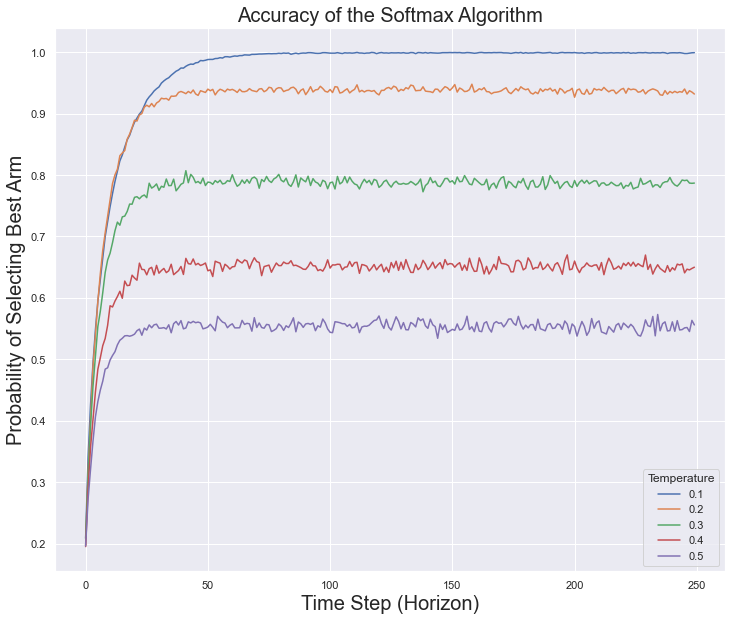

In [62]:
sns.set_style('darkgrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(12, 10)})
sns.lineplot(x=range(0, HORIZON), y=temp_01_best_arm_probs, label='0.1')
sns.lineplot(x=range(0, HORIZON), y=temp_02_best_arm_probs, label='0.2')
sns.lineplot(x=range(0, HORIZON), y=temp_03_best_arm_probs, label='0.3')
sns.lineplot(x=range(0, HORIZON), y=temp_04_best_arm_probs, label='0.4')
sns.lineplot(x=range(0, HORIZON), y=temp_05_best_arm_probs, label='0.5')
plt.legend(title='Temperature')
plt.xlabel('Time Step (Horizon)', size=20)
plt.ylabel('Probability of Selecting Best Arm', size=20)
plt.title('Accuracy of the Softmax Algorithm', size=20)

Looking at the probability that the softmax algorithm selects the right arm, we see that it starts to select the right arm 100% of the time if we wait long enough. This is a big improvement over the epsilon-Greedy algorithm, which never got past the intrinsic errors caused by the purely random exploration strategy it used. In our standard test case, there is one standout arm and the softmax algorithm is able to find it and exploit it far more effectively than the epsilon-Greedy algorithm.

We see the same results looking at the average reward rates plotted in Figure below, except that the rewards are capped at 0.9 instead of 1.0 because 0.9 is the expected rate of reward associated with the best arm in our test suite.

In [67]:
RESULT_INDEX = 3 # Index 3 is the rewards

# Split the simulations into individual simulation runs
temp_01 = np.array([temp_results[0][RESULT_INDEX][i:i+HORIZON] for i in range(0, len(temp_results[0][RESULT_INDEX]), HORIZON)])

# Count how often the best arm was selected then divide by the total number of simulations to obtain the probability of selecting the best arm at each time point 
# Taking sum where temp_01 == 2 becuase index of best arm is 2 as determined above
temp_01_result = np.mean(temp_01, axis=0)

temp_02 = np.array([temp_results[1][RESULT_INDEX][i:i+HORIZON] for i in range(0, len(temp_results[1][RESULT_INDEX]), HORIZON)])
temp_02_result = np.mean(temp_02, axis=0)

temp_03 = np.array([temp_results[2][RESULT_INDEX][i:i+HORIZON] for i in range(0, len(temp_results[1][RESULT_INDEX]), HORIZON)])
temp_03_result = np.mean(temp_03, axis=0)

temp_04 = np.array([temp_results[3][RESULT_INDEX][i:i+HORIZON] for i in range(0, len(temp_results[1][RESULT_INDEX]), HORIZON)])
temp_04_result = np.mean(temp_04, axis=0)

temp_05 = np.array([temp_results[4][RESULT_INDEX][i:i+HORIZON] for i in range(0, len(temp_results[1][RESULT_INDEX]), HORIZON)])
temp_05_result = np.mean(temp_05, axis=0)

Text(0.5, 1.0, 'Accuracy of the Softmax Algorithm')

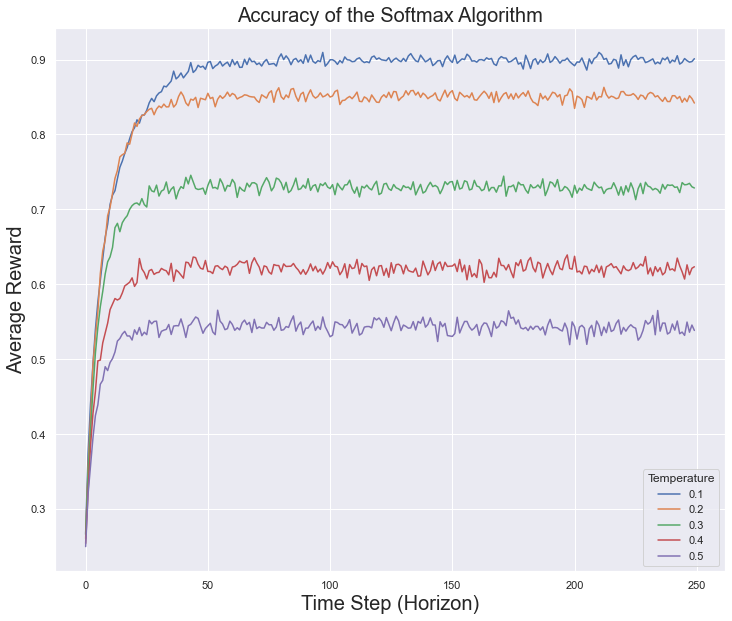

In [69]:
sns.set_style('darkgrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(12, 10)})
sns.lineplot(x=range(0, HORIZON), y=temp_01_result, label='0.1')
sns.lineplot(x=range(0, HORIZON), y=temp_02_result, label='0.2')
sns.lineplot(x=range(0, HORIZON), y=temp_03_result, label='0.3')
sns.lineplot(x=range(0, HORIZON), y=temp_04_result, label='0.4')
sns.lineplot(x=range(0, HORIZON), y=temp_05_result, label='0.5')
plt.legend(title='Temperature')
plt.xlabel('Time Step (Horizon)', size=20)
plt.ylabel('Average Reward', size=20)
plt.title('Accuracy of the Softmax Algorithm', size=20)

Finally, we can get more insight into the different temperature settings we can use by looking at the cumulative rewards earned as shown in Figure below. In this figure, we can see that the lowest temperature setting we used, 0.1, gives us the best results nearly right from the start. This is typical in settings in which there are clear differences between arms. It’s much less likely that the low level of exploration we’re seeing from the 0.1 temperature Softmax will be ideal if the arms are closer together.

In [70]:
RESULT_INDEX = 4 # Index 4 is the cumulative rewards

# Split the simulations into individual simulation runs
temp_01 = np.array([temp_results[0][RESULT_INDEX][i:i+HORIZON] for i in range(0, len(temp_results[0][RESULT_INDEX]), HORIZON)])

# Count how often the best arm was selected then divide by the total number of simulations to obtain the probability of selecting the best arm at each time point 
# Taking sum where temp_01 == 2 becuase index of best arm is 2 as determined above
temp_01_result = np.mean(temp_01, axis=0)

temp_02 = np.array([temp_results[1][RESULT_INDEX][i:i+HORIZON] for i in range(0, len(temp_results[1][RESULT_INDEX]), HORIZON)])
temp_02_result = np.mean(temp_02, axis=0)

temp_03 = np.array([temp_results[2][RESULT_INDEX][i:i+HORIZON] for i in range(0, len(temp_results[1][RESULT_INDEX]), HORIZON)])
temp_03_result = np.mean(temp_03, axis=0)

temp_04 = np.array([temp_results[3][RESULT_INDEX][i:i+HORIZON] for i in range(0, len(temp_results[1][RESULT_INDEX]), HORIZON)])
temp_04_result = np.mean(temp_04, axis=0)

temp_05 = np.array([temp_results[4][RESULT_INDEX][i:i+HORIZON] for i in range(0, len(temp_results[1][RESULT_INDEX]), HORIZON)])
temp_05_result = np.mean(temp_05, axis=0)

Text(0.5, 1.0, 'Cumulative Reward of the Softmax Algorithm')

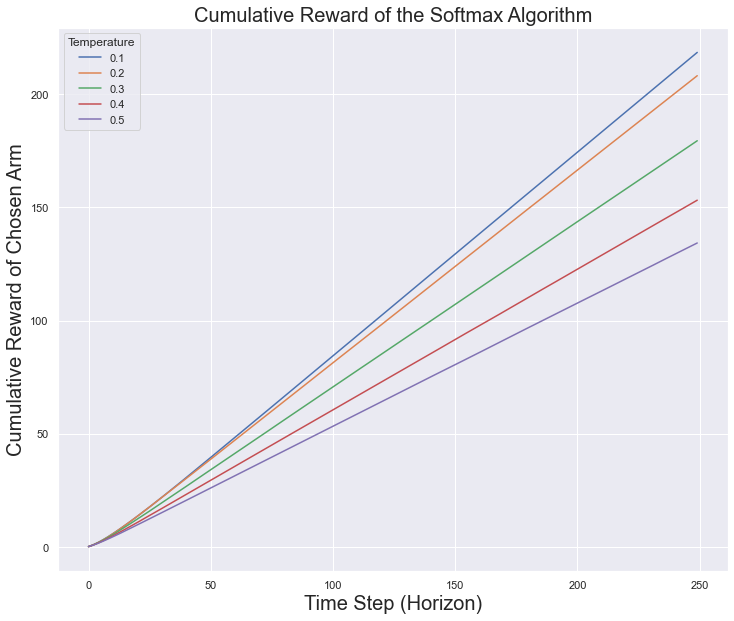

In [71]:
sns.set_style('darkgrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(12, 10)})
sns.lineplot(x=range(0, HORIZON), y=temp_01_result, label='0.1')
sns.lineplot(x=range(0, HORIZON), y=temp_02_result, label='0.2')
sns.lineplot(x=range(0, HORIZON), y=temp_03_result, label='0.3')
sns.lineplot(x=range(0, HORIZON), y=temp_04_result, label='0.4')
sns.lineplot(x=range(0, HORIZON), y=temp_05_result, label='0.5')
plt.legend(title='Temperature')
plt.xlabel('Time Step (Horizon)', size=20)
plt.ylabel('Cumulative Reward of Chosen Arm', size=20)
plt.title('Cumulative Reward of the Softmax Algorithm', size=20)

## The Annealing Softmax Algorithm

It's often a good idea to encourage an algorithm to explore less over time. In the Softmax algorithm, we can achieve that by slowly decreasing the temperature, which we call annealing. The name annealing is based on a metaphor about blacksmithing. For a blacksmith, annealing is a process in which the blacksmith slowly decreases the temperature at which he works with molten melt so that it becomes more solid and less flexible. This is helpful for building stronger materials as the metal gets closer to its final, desired shape.

For bandit algorithms, we can metaphorically decrease the temperature by changing the temperature parameter. This will make our algorithm exploit the best arm more often and settle into its final deterministic strategy for choosing an arm. We’ll set up a system to do that automatically in this last in this notebook.

Before we go any further, let’s give two equivalent definitions of the term annealing:
- Annealing is the process of decreasing the temperature in a Softmax algorithm over time.
- Annealing is a process of modifying a bandit algorithm’s behavior so that it will explore less over time.

Why are these definitions the same thing? The first definition is really a special case of the second definition, because the Softmax algorithm will explore less over time if we decrease the temperature parameter tau. So our annealing algorithm will really be a strategy for slowly lowering the temperature over time. Below, we implement a full annealing strategy, based on two simple lines of code:

In [ ]:
import math

t = sum(self.counts) + 1
temperature = 1 / math.log(t + 0.0000001)

What’s going on here? It’s easiest to understand this line by imagining what happens when `t = 1`. In that case, we set `temperature = 1 / math.log(1.0000001)`, which is very close to being infinite. So the temperature is extremely high and the system will explore almost completely randomly.

But, as `t` goes up, the temperature will get lower and lower. Because we use logarithms, this decrease isn’t extremely rapid: rather, it's just rapid enough to be effective. This division by a logarithmically scaled version of t isn’t always the best approach to annealing. In the exercises for this chapter, we encourage you to play with other annealing rules that decrease the temperature faster or that decrease the temperature over discrete blocks of time, rather than on every single iteration.

Before we run those experiments, though, we need to implement the full annealing Softmax algorithm. We do that below:

In [77]:
import math
import random

def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    for i in range(len(probs)):
        prob = probs[i] 
        cum_prob += prob
        if cum_prob > z:
            return i
    return len(probs) - 1

class AnnealingSoftmax:

    def __init__(self, counts, values):
        self.counts = counts 
        self.values = values

    def initialise(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]

    def select_arm(self):
        t = sum(self.counts) + 1
        temperature = 1 / math.log(t + 0.0000001)        
        
        z = sum([math.exp(v / temperature) for v in self.values])
        probs = [math.exp(v / temperature) / z for v in self.values] 
        return categorical_draw(probs)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward 
        self.values[chosen_arm] = new_value

How useful is this change to the Softmax algorithm to make it anneal? We can judge that by running simulations of the annealing Softmax algorithm and comparing the results with our standard Softmax algorithm that used a constant temperature setting.

In [93]:
import random

random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
print(f"Best arm is {ind_max(means)}")

Best arm is 2


In [109]:
# temp_results = []

N_SIMS = 5000 # Number of simulations to run
HORIZON = 250 # Number of time points in each simulation

algo = AnnealingSoftmax([], [])
algo.initialise(n_arms)
results = test_algorithm(algo, arms, N_SIMS, HORIZON)

# temp_results.append(results)

In [113]:
RESULT_INDEX = 2 # Index 2 is the selected arms

# Split the simulations into individual simulation runs
selected_arms = np.array([results[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])

# Count how often the best arm was selected then divide by the total number of simulations to obtain the probability of selecting the best arm at each time point 
# Taking sum where temp_01 == 2 becuase index of best arm is 2 as determined above
best_arm_probs = np.sum(selected_arms == 2, axis=0) / N_SIMS

Text(0.5, 1.0, 'Accuracy of the Softmax Algorithm')

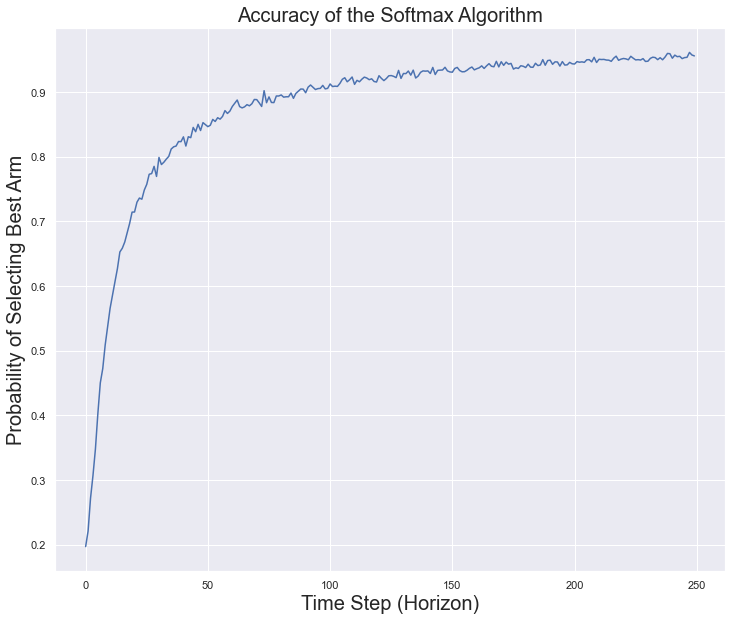

In [117]:
sns.set_style('darkgrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(12, 10)})
sns.lineplot(x=range(0, HORIZON), y=temp_01_best_arm_probs)
plt.xlabel('Time Step (Horizon)', size=20)
plt.ylabel('Probability of Selecting Best Arm', size=20)
plt.title('Accuracy of the Softmax Algorithm', size=20)

In [121]:
RESULT_INDEX = 3 # Index 3 is the rewards

# Split the simulations into individual simulation runs
arm_rewards = np.array([results[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])

# Count how often the best arm was selected then divide by the total number of simulations to obtain the probability of selecting the best arm at each time point 
mean_rewards = np.mean(arm_rewards, axis=0)

Text(0.5, 1.0, 'Accuracy of the Softmax Algorithm')

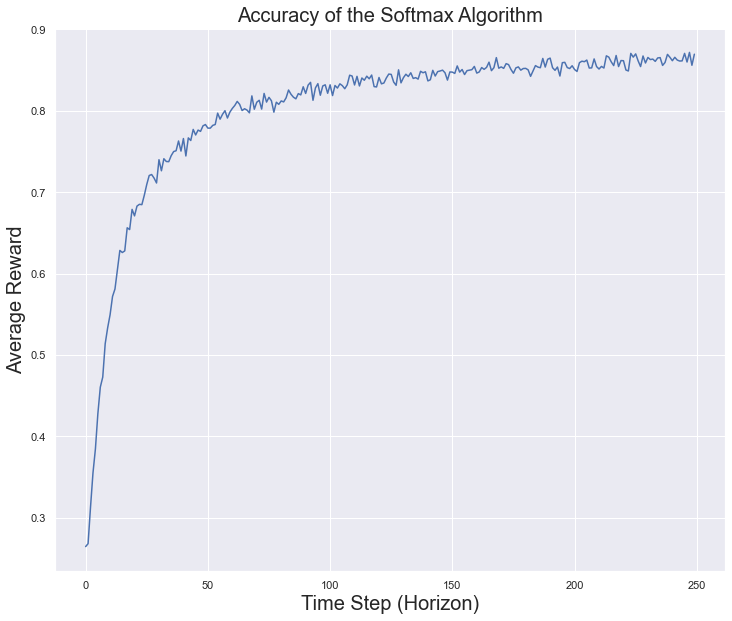

In [122]:
sns.set_style('darkgrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(12, 10)})
sns.lineplot(x=range(0, HORIZON), y=mean_rewards)
plt.xlabel('Time Step (Horizon)', size=20)
plt.ylabel('Average Reward', size=20)
plt.title('Accuracy of the Softmax Algorithm', size=20)

In [123]:
RESULT_INDEX = 4 # Index 4 is the cumulative rewards

# Split the simulations into individual simulation runs
cum_rewards = np.array([results[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
mean_cum_rewards = np.mean(cum_rewards, axis=0)

Text(0.5, 1.0, 'Cumulative Reward of the Softmax Algorithm')

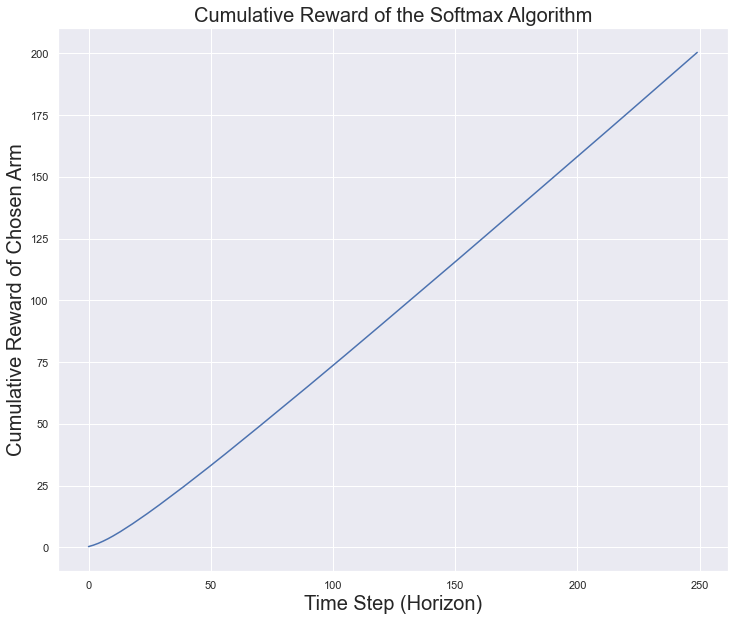

In [124]:
sns.set_style('darkgrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(12, 10)})
sns.lineplot(x=range(0, HORIZON), y=mean_cum_rewards)
plt.xlabel('Time Step (Horizon)', size=20)
plt.ylabel('Cumulative Reward of Chosen Arm', size=20)
plt.title('Cumulative Reward of the Softmax Algorithm', size=20)

As you can see by looking at these graphs, the system doesn’t reach perfect performance as quickly as the best of our hard-coded temperature settings in the previous set of graphs. But the algorithm reaches its peak performance much faster than the worse of our settings and reaches a higher peak. In many ways, it's the fact that we’re doing not much worse than our best case that really matters, because we only knew which tem‐ perature setting was best after the fact: in practice, we’d have to experiment with different temperature settings to find one that would work well. That's a non-trivial task for a system that needs to be deployed in the real world to be fully tested, so the use of annealing can be a real improvement. You should always try to avoid being forced to use your intuition to set any parameters that can affect a bandit algorithm when it’s deployed in the wild.